In [19]:
# Importing required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, roc_auc_score, classification_report, accuracy_score
from imblearn.over_sampling import SMOTE

# Step 1: Load the dataset
# Load the dataset from a CSV file into a Pandas DataFrame.
# Replace "StudentPerformanceFactorsAdjusted.csv" with the actual file path if necessary.
df = pd.read_csv("StudentPerformanceFactorsAdjusted.csv")

# Step 2: Encode categorical variables
# Initialize a dictionary to store LabelEncoder objects for each categorical column.
label_encoders = {}
# Identify all categorical columns in the DataFrame.
categorical_columns = df.select_dtypes(include='object').columns

# Loop through each categorical column, encode the values, and update the DataFrame.
for col in categorical_columns:
    le = LabelEncoder()  # Create a LabelEncoder instance.
    df[col] = le.fit_transform(df[col])  # Transform the column values into numeric codes.
    label_encoders[col] = le  # Store the encoder for potential inverse transformation.

# Step 3: Check and handle missing values
# Fill missing values in the DataFrame with the median of each column.
# This approach minimizes bias by replacing missing data with the central tendency.
df.fillna(df.median(), inplace=True)

# Step 4: Separate features and target variable
# Separate the features (input variables) and the target variable (output).
# 'Exam_Score' is the target variable, and all other columns are considered features.
X = df.drop('Exam_Score', axis=1)  # Features.
y = df['Exam_Score']              # Target variable.

# Step 5: Aggregate scores into ranges
# Define a function to group the 'Exam_Score' into predefined score ranges.
# Each range corresponds to specific grade bands for easier analysis.
def aggregate_classes(score):
    if score >= 55 and score <= 60:
        return "55-60"
    elif score >= 61 and score <= 65:
        return "61-65"
    elif score >= 66 and score <= 70:
        return "66-70"
    elif score >= 71 and score <= 75:
        return "71-75"
    elif score >= 76 and score <= 80:
        return "76-80"
    else:
        return "81+"

# Apply the grouping function to the target variable to create aggregated score categories.
y_aggregated = y.map(aggregate_classes)

# Step 6: Normalize numerical features
# Use StandardScaler to normalize the numerical features.
# Normalization scales features to have zero mean and unit variance, improving model performance.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [20]:
# Step 7: Split data into training and testing sets
# Split the normalized features and target variable into training and testing subsets.
# 80% of the data is used for training, and 20% is used for testing.
# Setting 'random_state=42' ensures reproducibility of the split.
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 8: Train the KNN model for classification
# Initialize a K-Nearest Neighbors (KNN) classifier with 5 neighbors.
knn = KNeighborsClassifier(n_neighbors=5)

# Define custom scorers
# Create a dictionary of evaluation metrics for cross-validation.
# The metrics include accuracy, precision, recall, F1 score, and ROC-AUC.
# Weighted averages are used for multi-class classification.
scorers = {
    'accuracy': 'accuracy',  # Proportion of correctly classified samples.
    'precision': make_scorer(precision_score, average='weighted', zero_division=0),  # Precision score.
    'recall': make_scorer(recall_score, average='weighted', zero_division=0),        # Recall score.
    'f1': make_scorer(f1_score, average='weighted', zero_division=0),                # F1 score.
    'roc_auc': make_scorer(roc_auc_score, average='macro', multi_class='ovr')       # ROC-AUC score.
}

# Perform cross-validation
# Use 5-fold cross-validation to evaluate the KNN classifier on the entire dataset.
# Compute the defined metrics for each fold and store the results.
cv_results = cross_validate(knn, X_scaled, y, cv=5, scoring=scorers)

# Calculate metrics
# Calculate the mean and standard deviation for each metric across the folds.
metrics = {
    "Accuracy": (cv_results['test_accuracy'].mean(), cv_results['test_accuracy'].std()),
    "Precision": (cv_results['test_precision'].mean(), cv_results['test_precision'].std()),
    "Recall": (cv_results['test_recall'].mean(), cv_results['test_recall'].std()),
    "F1": (cv_results['test_f1'].mean(), cv_results['test_f1'].std()),
    "AUC": (cv_results['test_roc_auc'].mean(), cv_results['test_roc_auc'].std())
}

# Step 9: Display metrics
# Print the cross-validation results for each metric, including the mean and standard deviation.
print("\nKNN Metrics Before Balancing:")
for metric, (mean, std) in metrics.items():
    print(f"{metric}: Mean = {mean:.4f}, Std = {std:.4f}")

import warnings
warnings.filterwarnings('ignore')


# Step 10: Train the model on training data and evaluate
# Train the KNN classifier on the training data.
knn.fit(X_train, y_train)
# Predict the target variable for the test data using the trained model.
y_pred = knn.predict(X_test)

# Display classification report for test set
# Print a detailed classification report that includes precision, recall, F1 score, and support for each class.
print("\nClassification Report (Test Set) Before Balancing:")
print(classification_report(y_test, y_pred, zero_division=1))

# Accuracy score for test data
# Calculate and display the overall accuracy for the test set predictions.
accuracy = accuracy_score(y_test, y_pred)
print(f"\nTest Set Accuracy: {accuracy:.4f}")


KNN Metrics Before Balancing:
Accuracy: Mean = 0.1389, Std = 0.0076
Precision: Mean = 0.1431, Std = 0.0086
Recall: Mean = 0.1389, Std = 0.0076
F1: Mean = 0.1347, Std = 0.0075
AUC: Mean = nan, Std = nan

Classification Report (Test Set) Before Balancing:
              precision    recall  f1-score   support

          55       1.00      0.00      0.00         1
          57       1.00      0.00      0.00         2
          58       0.00      0.00      0.00         3
          59       0.14      0.20      0.17         5
          60       0.20      0.31      0.24        13
          61       0.08      0.15      0.11        26
          62       0.18      0.22      0.20        54
          63       0.11      0.18      0.14        77
          64       0.13      0.19      0.15        94
          65       0.16      0.18      0.17       148
          66       0.15      0.19      0.17       144
          67       0.10      0.11      0.10       142
          68       0.13      0.15      0.1

In [21]:
# Step 11: Apply SMOTE to balance the dataset
# Use Synthetic Minority Oversampling Technique (SMOTE) to handle class imbalance in the dataset.
# SMOTE generates synthetic samples for minority classes by interpolating between existing samples.
# This step ensures that all classes have an equal number of samples, improving model performance on imbalanced datasets.
smote = SMOTE(random_state=42)  # Set random_state for reproducibility.
X_balanced, y_balanced = smote.fit_resample(X_scaled, y_aggregated)  # Resample the data to balance the classes.

# Step 12: Split data into training and testing sets
# Split the balanced dataset into training and testing subsets.
# 80% of the data is used for training, and 20% is used for testing.
# The split ensures that both the features and the target variable are properly separated.
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Step 13: Train the KNN model
# Initialize a K-Nearest Neighbors (KNN) classifier with 5 neighbors (default hyperparameter).
knn = KNeighborsClassifier(n_neighbors=5)
# Train the KNN model using the training data.
knn.fit(X_train, y_train)

# Step 14: Make predictions
# Use the trained KNN model to predict the target variable for the test data.
y_pred = knn.predict(X_test)

# Hyperparameter tuning
# Use GridSearchCV to find the optimal number of neighbors for the KNN classifier.
# The hyperparameter tuning process evaluates the model's performance across a range of neighbor values (1 to 20).
from sklearn.model_selection import GridSearchCV

# Define a parameter grid for the number of neighbors.
param_grid = {'n_neighbors': range(1, 21)}
# Initialize GridSearchCV with KNN and the parameter grid.
# Use 5-fold cross-validation to evaluate the performance of each parameter setting.
grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
# Fit GridSearchCV on the training data to determine the best hyperparameter value.
grid.fit(X_train, y_train)

# Print the optimal number of neighbors found through GridSearchCV.
print(f"Best number of neighbors: {grid.best_params_}")


Best number of neighbors: {'n_neighbors': 1}


In [22]:
# Step 8: Train the KNN model for classification
# Initialize a K-Nearest Neighbors (KNN) classifier with 5 neighbors.
# The KNN algorithm is used for classification based on the majority vote from the nearest neighbors.
knn = KNeighborsClassifier(n_neighbors=5)

# Define custom scorers
# Create a dictionary of evaluation metrics for cross-validation.
# The metrics include accuracy, precision, recall, F1 score, and ROC-AUC.
# The 'weighted' average is used for multi-class classification, considering class imbalance.
scorers = {
    'accuracy': 'accuracy',  # Proportion of correctly classified samples.
    'precision': make_scorer(precision_score, average='weighted', zero_division=0),  # Weighted precision score.
    'recall': make_scorer(recall_score, average='weighted'),  # Weighted recall score.
    'f1': make_scorer(f1_score, average='weighted'),  # Weighted F1 score.
    'roc_auc': make_scorer(roc_auc_score, average='weighted', multi_class='ovr', response_method='predict_proba')  # ROC-AUC score, multi-class.
}

# Perform cross-validation
# Use 5-fold cross-validation to evaluate the KNN classifier on the training data.
# The custom scorers are applied to compute multiple evaluation metrics.
cv_results = cross_validate(knn, X_train, y_train, cv=5, scoring=scorers)

# Calculate metrics
# Calculate the mean and standard deviation for each metric across the cross-validation folds.
# This will help assess the model's performance and stability.
metrics = {
    "Accuracy": (cv_results['test_accuracy'].mean(), cv_results['test_accuracy'].std()),
    "Precision": (cv_results['test_precision'].mean(), cv_results['test_precision'].std()),
    "Recall": (cv_results['test_recall'].mean(), cv_results['test_recall'].std()),
    "F1": (cv_results['test_f1'].mean(), cv_results['test_f1'].std()),
    "AUC": (cv_results['test_roc_auc'].mean(), cv_results['test_roc_auc'].std())
}

# Step 9: Display metrics
# Print out the evaluation metrics for the KNN classifier, including the mean and standard deviation for each metric.
print("\nKNN Metrics:")
for metric, (mean, std) in metrics.items():
    print(f"{metric}: Mean = {mean:.4f}, Std = {std:.4f}")

# Train the model
# Fit the KNN model using the entire training data.
knn.fit(X_train, y_train)

# Step 9: Make predictions
# Predict the target variable for the test set using the trained KNN model.
y_pred = knn.predict(X_test)

# Classification report
# Print a detailed classification report for the test data, which includes precision, recall, F1 score, and support for each class.
# Setting zero_division=1 ensures that division by zero in precision/recall calculations doesn't result in errors.
print("\nClassification Report After Balancing:")
print(classification_report(y_test, y_pred, zero_division=1))

# Accuracy score for test data
# Calculate and display the overall accuracy of the model on the test data.
accuracy = accuracy_score(y_test, y_pred)
print(f"\nTest Set Accuracy: {accuracy:.4f}")



KNN Metrics:
Accuracy: Mean = 0.8455, Std = 0.0043
Precision: Mean = 0.8406, Std = 0.0068
Recall: Mean = 0.8455, Std = 0.0043
F1: Mean = 0.8303, Std = 0.0044
AUC: Mean = 0.9673, Std = 0.0007

Classification Report After Balancing:
              precision    recall  f1-score   support

       55-60       0.88      1.00      0.94       656
       61-65       0.76      0.76      0.76       733
       66-70       0.75      0.40      0.52       635
       71-75       0.81      0.94      0.87       664
       76-80       0.98      1.00      0.99       715
         81+       0.90      1.00      0.95       669

    accuracy                           0.85      4072
   macro avg       0.85      0.85      0.84      4072
weighted avg       0.85      0.85      0.84      4072


Test Set Accuracy: 0.8546


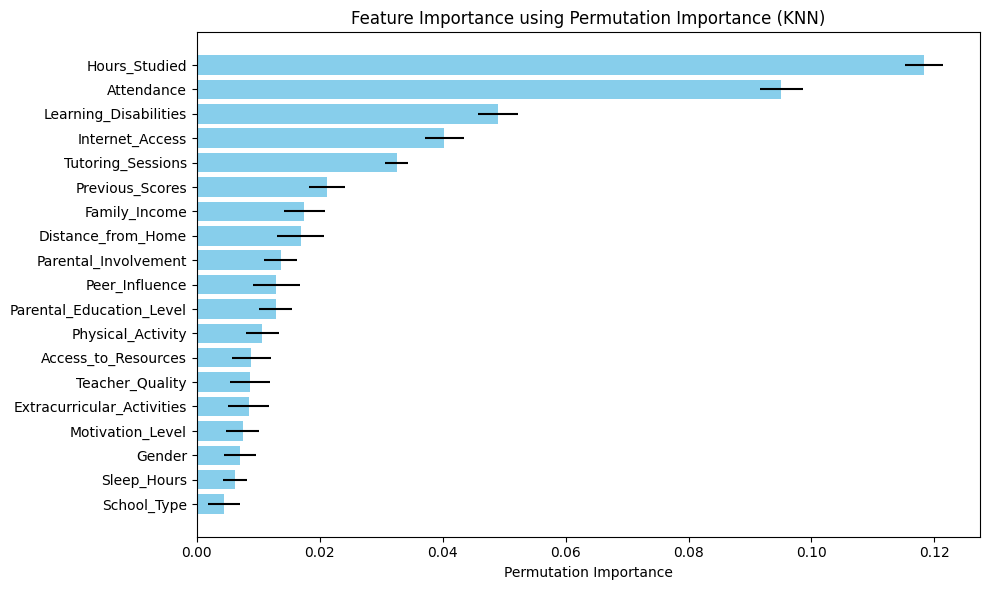

In [23]:
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
import numpy as np

# Step 1: Train the KNN model (this is already done above)
# knn.fit(X_balanced, y_balanced)

# Step 2: Perform permutation importance on the trained model
# For this, we'll use the test set (X_test, y_test)
result = permutation_importance(knn, X_test, y_test, n_repeats=10, random_state=42)

# Step 3: Get the feature importances
importance = result.importances_mean
std = result.importances_std

# Step 4: Create a bar chart to visualize feature importance
features = X.columns 

# Sorting features by importance
sorted_idx = np.argsort(importance)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(features[sorted_idx], importance[sorted_idx], xerr=std[sorted_idx], color='skyblue', align='center')
plt.xlabel('Permutation Importance')
plt.title('Feature Importance using Permutation Importance (KNN)')
plt.tight_layout()
plt.show()
